In [55]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

In [56]:
usage = pd.read_excel('houz electricity.xlsx')
usage['datetime'] = np.nan
for index, row in usage.iterrows():
    if isinstance(row['Date'],datetime):
        usage['datetime'][index] = row['Date'] + timedelta(hours=row['Start Time'].hour)
    else:
        usage['datetime'][index] = datetime.strptime(row['Date'],'%m/%d/%Y') + timedelta(hours=row['Start Time'].hour)
usage = usage.drop(columns='Date')
usage

/var/folders/rh/vbg2_t2n7n323x0x6b1lg8c40000gn/T/ipykernel_95227/1818038340.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usage['datetime'][index] = datetime.strptime(row['Date'],'%m/%d/%Y') + timedelta(hours=row['Start Time'].hour)


,Start Time,Usage (kWh),datetime
0,01:00:00,0.115,2023-07-01 01:00:00
1,02:00:00,0.140,2023-07-01 02:00:00
2,03:00:00,0.150,2023-07-01 03:00:00
3,04:00:00,0.125,2023-07-01 04:00:00
4,05:00:00,0.155,2023-07-01 05:00:00
...,...,...,...
1722,19:00:00,1.585,2023-09-10 19:00:00
1723,20:00:00,3.790,2023-09-10 20:00:00
1724,21:00:00,1.150,2023-09-10 21:00:00
1725,22:00:00,2.780,2023-09-10 22:00:00


In [57]:
weekends = (5, 6)
holidays = (datetime(2023, 7, 4), datetime(2023, 9, 4))
usage['weekday'] = np.nan
def weekday_or_nah(date):
    if date in holidays:
        return False
    if date.weekday() not in weekends:
        return True
    elif date.weekday() in weekends:
        return False
for index, row in usage.iterrows():
    usage['weekday'][index] = weekday_or_nah(row['datetime'])
usage_weekdays = usage[(usage['weekday'])].drop(columns='weekday')
usage_weekends_holidays = usage[usage['weekday'] == False].drop(columns='weekday')

/var/folders/rh/vbg2_t2n7n323x0x6b1lg8c40000gn/T/ipykernel_95227/2658311129.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usage['weekday'][index] = weekday_or_nah(row['datetime'])


In [78]:
usage_weekdays_hourly = usage_weekdays.groupby(by='Start Time').mean().reset_index()
usage_weekends_holidays_hourly = usage_weekends_holidays.groupby(by='Start Time').mean().reset_index()
usage_weekdays_hourly

/var/folders/rh/vbg2_t2n7n323x0x6b1lg8c40000gn/T/ipykernel_95227/2454365097.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  usage_weekdays_hourly = usage_weekdays.groupby(by='Start Time').mean().reset_index()
/var/folders/rh/vbg2_t2n7n323x0x6b1lg8c40000gn/T/ipykernel_95227/2454365097.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  usage_weekends_holidays_hourly = usage_weekends_holidays.groupby(by='Start Time').mean().reset_index()


,Start Time,Usage (kWh)
0,00:00:00,0.668646
1,01:00:00,0.568400
2,02:00:00,0.531900
3,03:00:00,0.497000
4,04:00:00,0.411200
5,05:00:00,0.364100
6,06:00:00,0.384200
7,07:00:00,0.439300
8,08:00:00,0.667700
9,09:00:00,0.523500


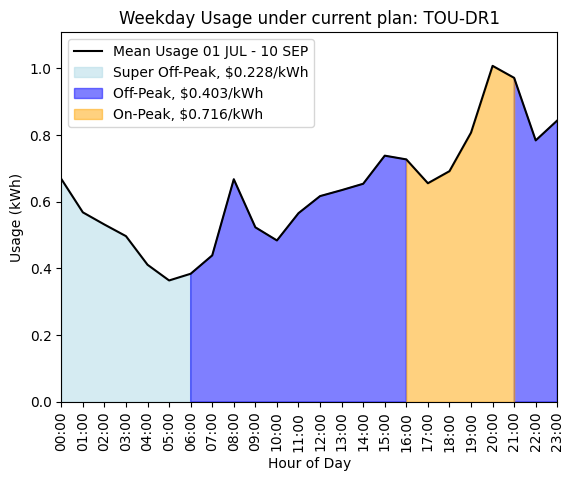

In [100]:
plt.plot(usage_weekdays_hourly['Usage (kWh)'], c='black', label='Mean Usage 01 JUL - 10 SEP')
plt.xlabel('Hour of Day')
plt.ylabel('Usage (kWh)')
super_off_peak_dr1_mask = (usage_weekdays_hourly.index <= 6)
off_peak_dr1_mask = ((usage_weekdays_hourly.index >= 6) & (usage_weekdays_hourly.index <= 16)) | (usage_weekdays_hourly.index >= 21)
on_peak_dr1_mask = (usage_weekdays_hourly.index >= 16) & (usage_weekdays_hourly.index <= 21)
plt.fill_between(usage_weekdays_hourly.index, usage_weekdays_hourly['Usage (kWh)'], where=super_off_peak_dr1_mask, color='lightblue', alpha=0.5, label='Super Off-Peak, $0.228/kWh')
plt.fill_between(usage_weekdays_hourly.index, usage_weekdays_hourly['Usage (kWh)'], where=off_peak_dr1_mask, color='blue', alpha=0.5, label='Off-Peak, $0.403/kWh')
plt.fill_between(usage_weekdays_hourly.index, usage_weekdays_hourly['Usage (kWh)'], where=on_peak_dr1_mask, color='orange', alpha=0.5, label='On-Peak, $0.716/kWh')
plt.title('Weekday Usage under current plan: TOU-DR1')
plt.xticks(usage_weekdays_hourly.index, ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'], rotation=90)
plt.xlim(0,23)
plt.ylim(0,np.max(usage_weekdays_hourly['Usage (kWh)']) * 1.1)
plt.legend()


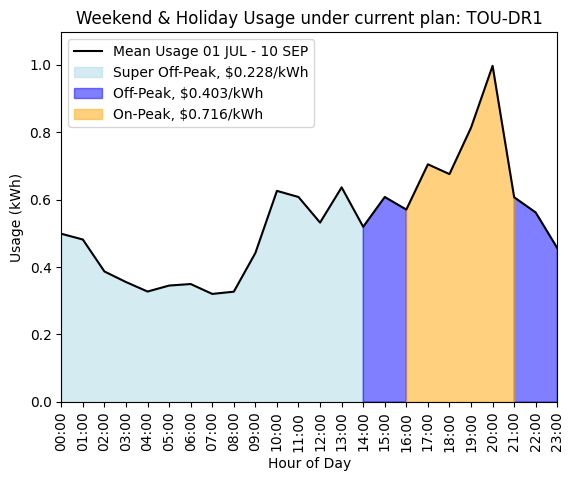

In [101]:
plt.plot(usage_weekends_holidays_hourly['Usage (kWh)'], c='black', label='Mean Usage 01 JUL - 10 SEP')
plt.xlabel('Hour of Day')
plt.ylabel('Usage (kWh)')
super_off_peak_dr1_weekends_holidays_mask = (usage_weekends_holidays_hourly.index <= 14)
off_peak_dr1_weekends_holiday_mask = ((usage_weekends_holidays_hourly.index >= 14) & (usage_weekends_holidays_hourly.index <= 16)) | (usage_weekends_holidays_hourly.index >= 21)
on_peak_dr1_holidays_hourly_mask = (usage_weekends_holidays_hourly.index >= 16) & (usage_weekends_holidays_hourly.index <= 21)
plt.fill_between(usage_weekends_holidays_hourly.index, usage_weekends_holidays_hourly['Usage (kWh)'], where=super_off_peak_dr1_weekends_holidays_mask, color='lightblue', alpha=0.5, label='Super Off-Peak, $0.228/kWh')
plt.fill_between(usage_weekends_holidays_hourly.index, usage_weekends_holidays_hourly['Usage (kWh)'], where=off_peak_dr1_weekends_holiday_mask, color='blue', alpha=0.5, label='Off-Peak, $0.403/kWh')
plt.fill_between(usage_weekends_holidays_hourly.index, usage_weekends_holidays_hourly['Usage (kWh)'], where=on_peak_dr1_holidays_hourly_mask, color='orange', alpha=0.5, label='On-Peak, $0.716/kWh')
plt.title('Weekend & Holiday Usage under current plan: TOU-DR1')
plt.xticks(usage_weekends_holidays_hourly.index, ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00'], rotation=90)
plt.xlim(0,23)
plt.ylim(0,np.max(usage_weekends_holidays_hourly['Usage (kWh)']) * 1.1)
plt.legend()
plt.text(0,1,'n= '+str(usage_weekends_holidays_hourly.shape[0]))

In [59]:
test_datetime = datetime.datetime(2023,7,1,18)
weekday_or_nah(test_datetime)

#schedule & pricing data available at https://www.sdge.com/residential/pricing-plans/about-our-pricing-plans/whenmatters
available_plans = ('tou_dr2', 'dr', 'tou_dr', 'tou_dr1')
super_off_peak_tou_dr1_weekday = (0, 1, 2, 3, 4, 5)
off_peak_tou_dr1_weekday = (6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23)
on_peak_tou_dr1_weekday = (16, 17, 18, 19, 20)
super_off_peak_tou_dr1_nah = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13)
off_peak_tou_dr1_nah = (14, 15, 21, 22, 23)
on_peak_tou_dr1_nah = (16, 17, 18, 19, 20)
super_off_peak_tou_dr1_price = 0.238 #($/kWh)
off_peak_tou_dr1_price = 0.403
on_peak_tou_dr1_price = 0.833

off_peak_tou_dr2 = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23)
on_peak_tou_dr2 = (16, 17, 18, 19, 20)
off_peak_tou_dr2_price = 0.331
on_peak_tou_dr2 = 0.724

#dr doesn't have any time sensitivity
dr_price = 0.452

on_peak_tou_dr_weekdays = (16, 17, 18, 19, 20)
off_peak_tou_dr1_weekdays = (6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 21, 22, 23)
super_off_peak_tou_dr1_weekdays= (0, 1, 2, 3, 4, 5)
on_peak_tou_dr_nah = (16, 17, 18, 19, 20)
off_peak_tou_dr_nah = (14, 15, 21, 22, 23)
super_off_peak = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)
on_peak_summer_tou_dr_price = 0.665
off_peak_summer_tou_dr_price = 0.569
super_off_peak_summer_tou_dr_price = 0.465

def cost_of_hour(datetime,plan):
    if plan == ''

SyntaxError: expected ':' (1979020813.py, line 35)

In [ ]:
#TODO dummy mode rn
datetimes = []
for index, row in usage.iterrows():
    date = row['Date']
    if isinstance(date, type(date_object)):
        datetime = datetime.combine(date,(row['Start Time']))
    else:
        datetime = datetime.combine(parser.parse(date),(row['Start Time']))
    datetimes.append(datetime)
usage['datetime'] = datetimes
#usage['datetime'] = parser.parse(str(usage['Date'])+str(usage['Start Time']))
#usage['weekday'] = usage['Date'].apply(weekday_or_nah)
usage

AttributeError: module 'datetime' has no attribute 'combine'

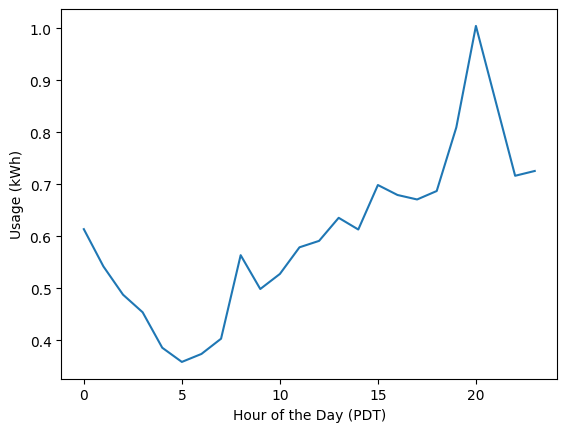

In [ ]:
hourly_usage = usage.groupby(by='Start Time').mean()
hourly_usage
plt.plot(hourly_usage['Usage (kWh)'].values)
#TODO make x axis nice
plt.xlabel('Hour of the Day (PDT)')
plt.ylabel('Usage (kWh)')
plt.show()